### Feature Engineering

We will use this notebook to do feature engineering.


In [1]:
# Set parameters 
BUCKET = 'opioid-care'
PROJECT = 'opioid-care'
REGION = 'us-central1'

import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [2]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
# Let's import libraries
import pandas as pd
pd.options.display.float_format='{:,.2f}'.format

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from google.datalab import bigquery as bq
import google.datalab.storage as storage
bucket = storage.Bucket('opioid-care')

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from io import BytesIO
from itertools import combinations

### Let's ingest data

In [4]:
# this is final dataset to split into eval and train dataset
query = 'select * from hackathon_opioid.best_features'
best_features = bq.Query(query).execute().result().to_dataframe()
best_features.shape
best_features.head(2)

(3141, 103)

,health_factors_pctile_within_state,length_of_life_pctile_within_state,pct_smokers,pct_physically_inactive,pct_excessive_drinking,preventable_hospitalization_rate,pct_some_college,pct_frequent_mental_distress,pct_diabetic,median_household_income,...,tedsd_psyprob_1,retaildrug_amobarbital__schedule_2_,retaildrug_amphetamine,retaildrug_fentanyl_base,retaildrug_lisdexamfetamine,retaildrug_methylphenidate__dl_d_l_isomers_,retaildrug_tapentadol,drug_overdose_mortality_rate,state,county
0,21.00,34.00,14.30,17.20,19.20,31.34,70.68,10.00,8.10,"61,653.00",...,0.29,48.77,"419,978.29","7,356.33","127,363.50","443,237.97","78,105.00",11.57,WA,Thurston
1,65.00,52.00,14.90,22.60,18.80,44.01,64.77,10.70,9.80,"52,673.00",...,0.29,48.77,"419,978.29","7,356.33","127,363.50","443,237.97","78,105.00",18.04,WA,Skamania


In [5]:
# Remove outlier from columns 
def remove_outliers(df, numerical_cols):
  for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range

    fence_low  = q1-1.5*iqr
    fence_high = q3 + 1.5*iqr
    
    #print(col, "Max:",df[col].max(), "Min:",df[col].min(), "q1:", q1, "q3:", q3, "iqr:", iqr, "low:",fence_low, "high:", fence_high)
    
    df[col] = df[col].mask(df[col] > fence_high, fence_high)
    df[col] = df[col].mask(df[col] < fence_low, fence_low)
  return df
  
best_features = remove_outliers(best_features, best_features.select_dtypes('number'))

In [6]:
query = 'select * from hackathon_opioid.master_data'
master_df = bq.Query(query).execute().result().to_dataframe()
master_df.shape
master_df.head()

(3141, 25)

,state,state_name,county,mentally_unhealthy_days,physically_unhealthy_days,pct_frequent_mental_distress,pct_excessive_drinking,injury_death_rate,age_adjusted_mortality,pct_frequent_physical_distress,...,pct_unemployed,length_of_life_pctile_within_state,median_household_income,pct_physically_inactive,length_of_life_quartile_within_state,pct_children_in_poverty,income_20th_percentile,pct_children_eligible_free_lunch,pct_diabetic,drug_overdose_mortality_rate
0,AK,Alaska,Skagway-Hoonah-Angoon,3.17,3.63,10.07,20.53,103.15,314.50,10.97,...,11.78,5.00,"57,495.98",20.00,1.00,24.50,"26,594.53",35.36,10.67,17.58
1,AK,Alaska,Wrangell-Petersburg,2.99,3.33,9.30,20.63,71.13,328.20,9.80,...,9.37,9.00,"54,748.91",20.80,1.00,13.11,"24,149.91",41.26,9.33,17.58
2,AL,Alabama,Macon,5.20,5.60,16.90,10.10,83.62,530.50,18.10,...,9.13,77.00,"28,518.00",31.10,4.00,44.40,"11,981.00",87.61,16.85,14.44
3,AL,Alabama,Pickens,5.00,5.10,15.90,11.40,94.15,515.50,16.40,...,8.22,56.00,"31,933.00",33.60,3.00,34.50,"11,224.00",55.06,15.50,14.44
4,AL,Alabama,Conecuh,5.30,5.80,17.10,10.30,97.75,542.60,18.45,...,10.74,81.00,"29,101.00",33.50,4.00,41.20,"10,693.00",82.91,16.85,14.44


In [7]:
def drop_duplicate_columns(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

df = pd.merge(master_df, best_features,  how='inner', on=['state','county'], suffixes=('', '_y'))
drop_duplicate_columns(df)

df.shape
df.head()

(3141, 116)

,state,state_name,county,mentally_unhealthy_days,physically_unhealthy_days,pct_frequent_mental_distress,pct_excessive_drinking,injury_death_rate,age_adjusted_mortality,pct_frequent_physical_distress,...,tedsd_sub2_7,tedsd_sub3_7,tedsd_dsmcrit_14,tedsd_psyprob_1,retaildrug_amobarbital__schedule_2_,retaildrug_amphetamine,retaildrug_fentanyl_base,retaildrug_lisdexamfetamine,retaildrug_methylphenidate__dl_d_l_isomers_,retaildrug_tapentadol
0,AK,Alaska,Skagway-Hoonah-Angoon,3.17,3.63,10.07,20.53,103.15,314.50,10.97,...,0.03,0.02,0.01,0.39,10.15,"31,327.52","1,059.96","9,784.34","32,818.62","7,749.50"
1,AK,Alaska,Wrangell-Petersburg,2.99,3.33,9.30,20.63,71.13,328.20,9.80,...,0.03,0.02,0.01,0.39,10.15,"31,327.52","1,059.96","9,784.34","32,818.62","7,749.50"
2,AL,Alabama,Macon,5.20,5.60,16.90,10.10,83.62,530.50,18.10,...,0.06,0.03,0.00,0.05,5.47,"507,395.33","7,558.55","285,042.66","290,860.23","262,860.00"
3,AL,Alabama,Pickens,5.00,5.10,15.90,11.40,94.15,515.50,16.40,...,0.06,0.03,0.00,0.05,5.47,"507,395.33","7,558.55","285,042.66","290,860.23","262,860.00"
4,AL,Alabama,Conecuh,5.30,5.80,17.10,10.30,97.75,542.60,18.45,...,0.06,0.03,0.00,0.05,5.47,"507,395.33","7,558.55","285,042.66","290,860.23","262,860.00"


In [8]:
# Feature ranking of counties data for clustering
numerical_cols = np.array(df.select_dtypes(['number']).columns)
categorical_cols = np.array(df.select_dtypes(['object']).columns)
categorical_cols

array(['state', 'state_name', 'county'], dtype=object)

In [9]:
# Check for data integrity
list(df[numerical_cols].loc[:, df[numerical_cols].isna().any()])

[]

In [10]:
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.preprocessing import MinMaxScaler,StandardScaler

X = df[numerical_cols]
y = df['drug_overdose_mortality_rate']

y_scaled = StandardScaler().fit_transform(np.array(y).reshape(-1, 1))
X_scaled = StandardScaler().fit_transform(X)

# select k best modeling
model_reduced = SelectKBest(f_regression, k='all').fit(X_scaled, y_scaled)

# get feature ranking by F-score
feature_ranking0 = pd.DataFrame()
feature_ranking0['drivers'] = X.columns
feature_ranking0['score'] = model_reduced.scores_
feature_ranking0['T/F'] = model_reduced.get_support()
feature_ranking = feature_ranking0[feature_ranking0['T/F']==True].sort_values(by='score', ascending=False).reset_index(drop=True).drop('T/F',axis=1)

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/envs/py3env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/envs/py3env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/envs/py3env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [11]:
# Based on our EDA and multiple test we figured out below features are good representation of our data...
target = ['drug_overdose_mortality_rate']
categorical_cols = ['state']
numerical_cols = [
'mentally_unhealthy_days',
 'physically_unhealthy_days',
 'pct_frequent_mental_distress',
 'pct_excessive_drinking',
 'injury_death_rate',
 'age_adjusted_mortality',
 'pct_frequent_physical_distress',
 'pct_smokers',
 'pct_insufficient_sleep',
 'preventable_hospitalization_rate',
 'pct_some_college',
 'pct_fair_or_poor_health',
 'pct_unemployed',
 'length_of_life_pctile_within_state',
 'median_household_income',
 'pct_physically_inactive',
'length_of_life_quartile_within_state',
 'pct_children_in_poverty',
 'income_20th_percentile',
 'pct_children_eligible_free_lunch',
 'pct_diabetic']

In [12]:
#  Check if all imp variables figured out by H2O model is in our merged dataset
h2o_features = pd.read_csv('h20_model_summary/ensemble_features_orig.txt')
h2o_features.head()

h2o_features = list(h2o_features['Original Feature'].str.lower().str.replace(' ','_').str.replace('-','_'))
for col in h2o_features:
  if col not in numerical_cols:
    print(col)

,Relative Importance,Original Feature
0,0.25,Length_of_Life_pctile_within_state
1,0.11,pct_Rural
2,0.06,pct_Excessive_Drinking
3,0.05,TEDSA_DSMCRIT_14
4,0.05,TEDSA_DSMCRIT_5


pct_rural
tedsa_dsmcrit_14
tedsa_dsmcrit_5
tedsa_frstuse2_7
nmhss_opraceperblk_1
nmhss_ipracetotasian_41_to_50
tedsa_arrests__9
tedsa_age_8
tedsa_frstuse3_5
health_factors_pctile_within_state
nmhss_treatfamthrpy
tedsa_sub3_7
nmhss_ipraceperunk_2
retaildrug_amphetamine
county
nmhss_focus_mental_health_treatment
nmhss_treattraumathrpy
retaildrug_tapentadol
tedsa_arrests_0
state
tedsd_sub3_7
tedsd_sub2_7


In [13]:
# Let's plot and find out variables distribution and anamoly detection
# Scatter and density plots
def plot_scatterMatrix(df, plotSize, textSize):
#  df = df.select_dtypes(include=[np.number])
#  df = df[[col for col in df if df[col].nunique>1]] # Keep columns with continuous values
#  columnNames = list(df)
  
  ax = pd.plotting.scatter_matrix(df, alpha=0.5, figsize=[plotSize, plotSize] , diagonal='kde', grid=True)
  #Change label rotation
  [s.xaxis.label.set_rotation(45) for s in ax.reshape(-1)]
  [s.yaxis.label.set_rotation(0) for s in ax.reshape(-1)]

  #May need to offset label when rotating to prevent overlap of figure
  [s.get_yaxis().set_label_coords(-0.3,0.5) for s in ax.reshape(-1)]

  #Hide all ticks
  [s.set_xticks(()) for s in ax.reshape(-1)]
  [s.set_yticks(()) for s in ax.reshape(-1)]
  corrs = df.corr().values
  for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
    ax[i, j].annotate('%.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
  plt.suptitle('Scatter and Density Plot')
  plt.show()

#plot_scatterMatrix(df[numerical_cols + target], 30,8)

In [14]:
def plot_outliers(df, df_features):
  for i in list(df[df_features]):
    df[i].plot.box()
    plt.show()
    
#plot_outliers(df, numerical_cols)

In [15]:
features_df = df[categorical_cols + numerical_cols + target]

In [16]:
label_df = features_df[target]
del features_df['drug_overdose_mortality_rate']

input_values = features_df[numerical_cols].values
labels = label_df.values

In [17]:
# Split training data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(input_values, labels, random_state=0)

In [18]:
def preprocessing(data, strategy='mean', scaling='std'):
  from sklearn.preprocessing import Imputer, StandardScaler
  data = Imputer(strategy=strategy).fit_transform(data)
  if scaling=='std':
    data = StandardScaler().fit_transform(data)
  return data
  
prep_train = preprocessing(X_train)
prep_val = preprocessing(X_val)

array([0.60192218, 0.10407381])

Text(0.5,1,'Counties Clusters')

Text(0.5,0,'PCA 1')

Text(0.5,0,'PCA 2')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


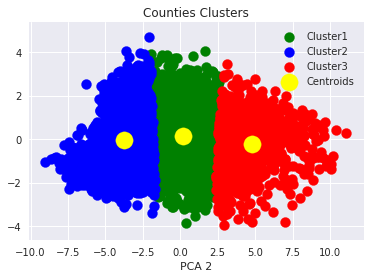

In [19]:

# Let's decompose data for visualization

pca = PCA(n_components=2)
pca_train = pca.fit_transform(np.vstack((prep_train, prep_val)))
explained_variance = pca.explained_variance_ratio_
explained_variance

pca_kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
y_pca_kmeans = pca_kmeans.fit_predict(pca_train)


plt.scatter(pca_train[y_pca_kmeans==0,0], pca_train[y_pca_kmeans == 0, 1], s=100, c='green', label='Cluster1')
plt.scatter(pca_train[y_pca_kmeans==1,0], pca_train[y_pca_kmeans == 1, 1], s=100, c='blue', label='Cluster2')
plt.scatter(pca_train[y_pca_kmeans==2,0], pca_train[y_pca_kmeans == 2, 1], s=100, c='red', label='Cluster3')
plt.scatter(pca_kmeans.cluster_centers_[:,0], pca_kmeans.cluster_centers_[:,1], s=300, c='yellow', label = 'Centroids')
plt.title('Counties Clusters')
plt.xlabel('PCA 1')
plt.xlabel('PCA 2')
plt.legend()
plt.show()

In [20]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
clust_labels = model.fit_predict(np.vstack((prep_train, prep_val)))
      
data = pd.DataFrame(clust_labels)
col_name = 'KMeans_label'
if col_name in df.columns:
  del df[col_name]
df.insert(loc=df.shape[1], column=col_name, value=data)

### Check accuracy for KMeans label

In [45]:

#Check if our clustering labels marked high risk counties correctly
high_risk_labeled_counties = df[df['KMeans_label']==2]

high_death_rate_counties_index = df.drug_overdose_mortality_rate.sort_values(ascending=False)[:len(high_risk_labeled_counties)].index
high_death_rate_counties = list(df[['state_name','county']].iloc[high_death_rate_counties_index, :]['county'])

top20_risk_counties_index = df.drug_overdose_mortality_rate.sort_values(ascending=False)[:20].index
top20_risk_counties =  list(df[['state_name','county']].iloc[top20_risk_counties_index, :]['county'])
non_matched_counties = []
for county in list(top20_risk_counties):
  if county not in list(high_risk_labeled_counties.county):
    non_matched_counties.append(county)
print("Non matched counties in top 20 high risk counties: ", non_matched_counties, "\n")

matched_counties = []
for county in list(high_death_rate_counties):
  if county in list(high_risk_labeled_counties.county):
    matched_counties.append(county)
    
print("Total counties: ", df.county.nunique())
print("Distinct counties labeled as high risk by Model: ", high_risk_labeled_counties.county.nunique(), "\n")
print("Matched counties: {} out of {} high risk counties".format(len(matched_counties), 1000))
print("Accuracy: ", len(matched_counties)/1000)


Non matched counties in top 20 high risk counties:  ['Tishomingo', 'Johnston', 'Berkeley', 'Cabell', 'McDowell'] 

Total counties:  1848
Distinct counties labeled as high risk by Model:  893 

Matched counties: 835 out of 1000 high risk counties
Accuracy:  0.835


In [32]:
df[['state_name','county'] + target + numerical_cols][df['county'].isin(['Tishomingo', 'Johnston', 'Berkeley', 'Cabell', 'McDowell'])]

,state_name,county,drug_overdose_mortality_rate,mentally_unhealthy_days,physically_unhealthy_days,pct_frequent_mental_distress,pct_excessive_drinking,injury_death_rate,age_adjusted_mortality,pct_frequent_physical_distress,...,pct_fair_or_poor_health,pct_unemployed,length_of_life_pctile_within_state,median_household_income,pct_physically_inactive,length_of_life_quartile_within_state,pct_children_in_poverty,income_20th_percentile,pct_children_eligible_free_lunch,pct_diabetic
42,West Virginia,McDowell,34.67,5.45,5.80,17.10,9.30,133.07,655.48,18.45,...,30.75,11.78,100.00,"24,707.00",38.30,4.00,46.20,"9,843.00",80.44,15.90
661,West Virginia,Cabell,34.67,4.50,4.70,14.60,11.30,90.66,495.80,14.20,...,20.50,5.48,66.00,"34,887.00",32.40,3.00,27.00,"13,834.00",48.67,11.80
1088,Mississippi,Tishomingo,34.67,3.90,4.10,12.40,14.00,119.55,546.00,12.40,...,18.60,7.90,65.00,"35,550.00",34.40,3.00,26.20,"16,637.00",68.70,11.80
1106,North Carolina,McDowell,11.86,3.90,4.20,12.00,14.40,75.14,415.70,12.60,...,18.90,6.33,56.00,"37,881.00",30.50,3.00,27.10,"15,543.00",56.67,10.90
1165,South Carolina,Berkeley,14.09,3.90,3.70,11.50,15.80,60.53,356.90,11.00,...,15.10,5.95,14.00,"52,436.00",25.00,1.00,20.70,"23,166.00",51.38,10.30
2025,Oklahoma,Johnston,34.67,4.60,4.90,14.50,12.30,133.07,572.70,14.90,...,22.30,6.99,93.00,"35,977.00",36.30,4.00,26.60,"16,534.00",63.99,13.20
2054,West Virginia,Berkeley,34.67,4.60,4.80,13.70,11.80,80.98,416.20,14.00,...,21.00,5.27,40.00,"56,737.00",27.70,2.00,19.40,"23,790.00",43.64,10.60
2394,North Carolina,Johnston,10.29,3.70,3.90,11.40,15.10,62.38,378.20,11.70,...,18.20,5.46,27.00,"50,055.00",24.10,2.00,21.60,"21,665.00",38.20,10.20


In [33]:
predict_data = df[numerical_cols][df['county'].isin(['Cabell', 'Raleigh', 'Clermont', 'Berkeley', 'Dickenson', 'St. Francois'])].values

### check accuracy for regression model for various variables on high level

In [34]:
# Build regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sk_lin_reg_model = LinearRegression().fit(prep_train, y_train)
predict_val = sk_lin_reg_model.predict(prep_val)
loss = 0.5 * np.sqrt(mean_squared_error(predict_val, y_val))
#loss = mean_squared_error(predict_val, y_val)
loss

2.229751568728799

In [35]:
sk_lin_reg_model.predict(StandardScaler().fit_transform(predict_data))

array([[12.18924774],
       [12.99465616],
       [12.42247424],
       [13.52140136],
       [19.22479237],
       [23.68255262],
       [14.50157323]])

In [36]:
"Intercept: ", sk_lin_reg_model.intercept_
"Coefficients/Weights: ", sk_lin_reg_model.coef_

('Intercept: ', array([15.50524253]))

('Coefficients/Weights: ',
 array([[ 5.31878201,  3.00168225, -4.9015997 , -1.75958047,  1.94316963,
         -0.24863079, -0.72964125,  0.64536857,  0.7555193 ,  0.40105322,
         -0.32502674, -1.35972713,  0.47907198,  1.54595461,  0.59505765,
         -0.61294012, -0.83132119, -0.85998715,  0.2737373 ,  0.42533616,
         -1.20849431]]))

In [37]:
#numerical_cols=final_numerical_cols
#target = ['drug_overdose_mortality_rate']

def find_all_combination(col_list):
  all_combinations = []
  for i in range(0, len(col_list)+1):
    for subset in combinations(col_list, i):
        all_combinations.append(list(subset))
  return all_combinations

#all_combinations = find_all_combination(numerical_cols)

def find_best_variables(all_combinations):
  for i, col_list in enumerate(all_combinations):
    if col_list:
      input_values = df[col_list].values
      labels = df[target].values
      X_train, X_val, y_train, y_val = train_test_split(input_values, labels, random_state=0)
      prep_train = preprocessing(X_train)
      prep_val = preprocessing(X_val)
      model = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
      clust_labels = model.fit_predict(np.vstack((prep_train, prep_val)))
      data = pd.DataFrame(clust_labels)
      col_name = 'KMeans_label'
      if col_name in df.columns:
        del df[col_name]
      df.insert(loc=df.shape[1], column=col_name, value=data)

      #Check if our clustering labels marked high risk counties correctly
      high_risk_labeled_counties = df[df['KMeans_label']==2]
      high_death_rate_counties_index = df.drug_overdose_mortality_rate.sort_values(ascending=False)[:len(high_risk_labeled_counties)].index
      high_death_rate_counties = list(df[['state_name','county']].iloc[high_death_rate_counties_index, :]['county'])
      
      matched_counties = []
      for county in list(high_death_rate_counties):
        if county in list(high_risk_labeled_counties.county):
          matched_counties.append(county)
          
      accuracy=0
      perf = len(matched_counties)/len(high_risk_labeled_counties)

      if perf > accuracy:
        accuracy = perf
        index = i
        best_subset = col_list
        
    
  return (index, accuracy, best_subset)

#find_best_variables(all_combinations)

In [39]:
# Write master dataframe into files for tensorflow regression model to predict death rate
def train_files(df, categorical_cols, numerical_cols,  target):
  train, validation = train_test_split(df[categorical_cols + numerical_cols + target], random_state=0)

  train.to_csv('data/train-data-01.csv', index=False, header=False)
  validation.to_csv('data/eval-data.csv', index=False, header=False)

  train[numerical_cols].describe().loc[['mean','std','max','min'],:].to_json("data/normalization_stats.json")

  validation.iloc[:,:-1].head(5).to_csv('data/test-data.csv', index=False, header=False)
  validation.iloc[:,:-1].head(5).to_json('data/test-data.json', orient='records')
  validation.iloc[:,:-1].head(1).to_json('data/new-data.json', orient='records')

  !gsutil cp -r data/* gs://opioid-care/ml_models/regression_opioid_deaths/data
    
train_files(master_df, categorical_cols, numerical_cols,  target)

Copying file://data/eval-data.csv [Content-Type=text/csv]...
Copying file://data/new-data.json [Content-Type=application/json]...            
Copying file://data/normalization_stats.json [Content-Type=application/json]... 
Copying file://data/test-data.csv [Content-Type=text/csv]...                    
/ [4 files][126.0 KiB/126.0 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://data/test-data.json [Content-Type=application/json]...
Copying file://data/train-data-01.csv [Content-Type=text/csv]...                
- [6 files][496.6 KiB/496.6 KiB]                                                
Operation completed over 6 objects/496.6 KiB.                                    


In [40]:
 train, validation = train_test_split(df[categorical_cols + numerical_cols + target], random_state=0)